Project 9

Yuqing Huang, 2018/03/14

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
kappa_seq = np.arange(0.3, 0.9+0.1, 0.1)
rbar_seq = np.arange(0.03, 0.09+0.01, 0.01)

In [10]:
def ZCB_CIR(tau, kappa, sigma, r_bar, r_t1):
    
    h1 = np.sqrt(kappa**2 + 2*sigma**2)
    h2 = (kappa + h1)/2.
    h3 = 2 * kappa * r_bar/sigma**2

    B = (np.exp(h1 * tau) - 1)/(h2 * (np.exp(h1 * tau) - 1) + h1)
    A = np.power(h1 * np.exp(h2 * tau)/(h2 * (np.exp(h1 * tau) - 1) + h1),h3)

    return A * np.exp(-B * r_t1)

Problem 1

In [11]:
def MBS_Numerix(wac, T, notional, r0, kappa, r_bar, sigma, simulations = 5000):
    np.random.seed(1)
    period = int(T * 12) # months
    ndays = int(T * 360) # days
    dt = 1/360.
    rm = wac/12.
    
    
    PV = np.zeros((simulations, period + 1))
    PV[:,0] = notional
    c = np.zeros((simulations, period))
    SY = [0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98]
    
    cir_mat = np.zeros((simulations, ndays + 1))
    cir_mat[:,0] = r0
    for i in range(1, ndays + 1):
        brownian = np.random.standard_normal(simulations)
        cir_mat[:,i] = cir_mat[:,i-1] + kappa * (r_bar -np.maximum(cir_mat[:,i-1], 0)) * dt +\
        sigma * brownian * np.sqrt(dt * np.maximum(cir_mat[:,i-1], 0))
        
    for i in range(period):
        # compute CPR
        BU = 0.3 + 0.7 * (PV[:,i]/PV[:,0])
        SG = min(1, (i+1)/30.)
        SY_i = SY[i%12]
        P10 = ZCB_CIR(10, kappa, sigma, r_bar, cir_mat[:, i*30])
        r10 = -1/10. * np.log(P10)
        RI = 0.28 + 0.14 * np.arctan(-8.57 + 430 * (wac - r10))
        CPR = BU * SG * SY_i * RI
        
        IP = PV[:,i] * rm
        SP = PV[:,i] * rm *(1/(1 - pow(1+rm, -period + i)) - 1.)
        PP = (PV[:,i] - SP) * (1 - pow(1 - CPR, 1/12.))
        PV[:,i+1] = PV[:,i] - SP - PP
        c[:,i] = IP + SP + PP
           
    
    step = 30 * np.arange(1, period + 1, 1)
    R_cir = np.array([dt * np.sum(cir_mat[:,1:j], axis = 1) for j in step]).T
    disc = np.exp(-R_cir)
    disc_c = disc * c
    MBS_sims = np.sum(disc_c, axis = 1)
    
    return np.mean(MBS_sims)

(a)

In [5]:
sol_1a = MBS_Numerix(wac = 0.08, T = 30, notional = 100000, r0 = 0.078, kappa = 0.6, r_bar = 0.08, sigma = 0.12, simulations = 5000)
print("1a: " + str(sol_1a))

1a: 100746.982324


(b)

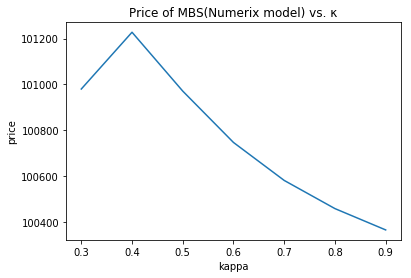

In [13]:
sol_1b = [MBS_Numerix(wac = 0.08, T = 30, notional = 100000, r0 = 0.078, 
               kappa = i, r_bar = 0.08, sigma = 0.12, simulations = 5000) for i in kappa_seq]

    
plt.plot(kappa_seq, sol_1b)
plt.xlabel("kappa")
plt.ylabel("price")
plt.title("Price of MBS(Numerix model) vs. κ")
plt.show()

(c)

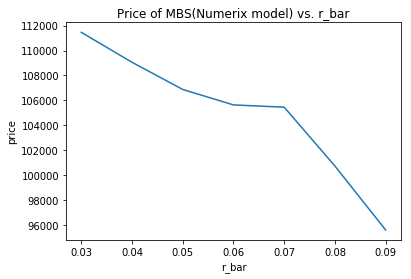

In [7]:
# (c)

sol_1c = [MBS_Numerix(wac = 0.08, T = 30, notional = 100000, r0 = 0.078, 
               kappa = 0.6, r_bar = i, sigma = 0.12, simulations = 5000) for i in rbar_seq]


plt.plot(rbar_seq, sol_1c)
plt.xlabel("r_bar")
plt.ylabel("price")
plt.title("Price of MBS(Numerix model) vs. r_bar")
plt.show()

We can observe that there are kinks in the two graphs above. One possible explanation is that we use full truncation to deal with negative $r_t$ in CIR simulations and thus the precision of outcome is affected (even if we increase the paths of simulations).

Problem 2

In [7]:
def MBS_PSA(wac, T, notional, r0, kappa, r_bar, sigma, simulations = 5000):
    np.random.seed(1)
    period = int(T * 12) # months
    ndays = int(T * 360) # days
    dt = 1/360.
    rm = wac/12.
    
    
    PV = [notional]
    c = []
    CPR = np.arange(0.002, 0.002*(30+1), 0.002)
    CPR = np.append(CPR, np.repeat(CPR[-1], period - 30))
    
    for i in range(period):
        IP = PV[-1] * rm
        SP = PV[-1] * rm *(1/(1 - pow(1+rm, -period + i)) - 1.)
        PP = (PV[-1] - SP)*(1 - pow(1 - CPR[i], 1/12.))
        PV_i = PV[-1] - SP - PP
        PV.append(PV_i)
        c.append(IP + SP + PP)
        
    
    cir_mat = np.zeros((simulations, ndays + 1))
    cir_mat[:,0] = r0
    for i in range(1, ndays + 1):
        brownian = np.random.standard_normal(simulations)
        cir_mat[:,i] = cir_mat[:,i-1] + kappa * (r_bar -cir_mat[:,i-1]) * dt + sigma * brownian * np.sqrt(dt * cir_mat[:,i-1])
        
    step = 30 * np.arange(1, period + 1, 1)
    
    R_cir = [dt * np.sum(cir_mat[:,1:j], axis = 1) for j in step]
    disc = [np.mean(np.exp(-R_cir[i])) for i in range(period)]
    MBS = np.dot(disc, c)
    
    return MBS

(a)

In [8]:
# (a)
sol_2a = MBS_PSA(wac = 0.08, T = 30, notional = 100000, r0 = 0.078, kappa = 0.6, r_bar = 0.08, sigma = 0.12, simulations = 5000)
print("2a: " + str(sol_2a))

2a: 100820.753357


(b)

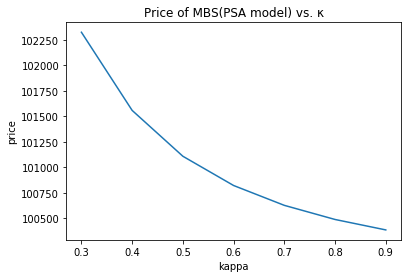

In [9]:
# (b)
sol_2b = [MBS_PSA(wac = 0.08, T = 30, notional = 100000, r0 = 0.078, 
               kappa = i, r_bar = 0.08, sigma = 0.12, simulations = 5000) for i in kappa_seq]

     
    
plt.plot(kappa_seq, sol_2b)
plt.xlabel("kappa")
plt.ylabel("price")
plt.title("Price of MBS(PSA model) vs. κ")
plt.show()

Problem 3

In [6]:
def MBS_Numerix_OAS(wac, T, notional, r0, kappa, r_bar, sigma, x, simulations = 5000):
    np.random.seed(1)
    period = int(T * 12) # months
    ndays = int(T * 360) # days
    dt = 1/360.
    rm = wac/12.  
    
    PV = np.zeros((simulations, period + 1))
    PV[:,0] = notional
    c = np.zeros((simulations, period))
    SY = [0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98]
    
    cir_mat = np.zeros((simulations, ndays + 1))
    cir_mat[:,0] = r0
    for i in range(1, ndays + 1):
        brownian = np.random.standard_normal(simulations)
        cir_mat[:,i] = cir_mat[:,i-1] + kappa * (r_bar -np.maximum(cir_mat[:,i-1], 0)) * dt +\
        sigma * brownian * np.sqrt(dt * np.maximum(cir_mat[:,i-1], 0))
    
    for i in range(period):
        # compute CPR
        BU = 0.3 + 0.7 * (PV[:,i]/PV[:,0])
        SG = min(1, (i+1)/30.)
        SY_i = SY[i%12]
        P10 = ZCB_CIR(10, kappa, sigma, r_bar, cir_mat[:, i*30])
        r10 = -1/10. * np.log(P10)
        RI = 0.28 + 0.14 * np.arctan(-8.57 + 430 * (wac - r10))
        CPR = BU * SG * SY_i * RI
        
        IP = PV[:,i] * rm
        SP = PV[:,i] * rm *(1/(1 - pow(1+rm, -period + i)) - 1.)
        PP = (PV[:,i] - SP) * (1 - pow(1 - CPR, 1/12.))
        PV[:,i+1] = PV[:,i] - SP - PP
        c[:,i] = IP + SP + PP
        
    
    
    step = 30 * np.arange(1, period + 1, 1)
    pmt_date = np.arange(1/12., 1/12*(period+1), 1/12.)
    R_cir = np.array([dt * np.sum(cir_mat[:,1:j], axis = 1) for j in step]).T
    disc = np.exp(-R_cir - x*pmt_date)
    disc_c = disc * c
    MBS_sims = np.sum(disc_c, axis = 1)
    
    return np.mean(MBS_sims)

In [4]:
def solve_OAS(xtry):
    return MBS_Numerix_OAS(wac = 0.08, T = 30, notional = 100000, r0 = 0.078, kappa = 0.6, 
                           r_bar = 0.08, sigma = 0.12,x = xtry,simulations = 5000) - 110000


In [5]:
def bisection_OAS(a,b):
 
    while ((b-a) >= 0.00000001):
 
        # Find middle point
        c = (a+b)/2.
  
        # Check if middle point is root
        if (solve_OAS(c) == 0.0):
            break
  
        # Decide the side to repeat the steps
        if (solve_OAS(c)* solve_OAS(a) < 0):
            b = c
        else:
            a = c
             
    return c
     
OAS = bisection_OAS(a = -0.1, b = 0.1)

In [8]:
print("OAS: " + str(OAS))

OAS: -0.012601429224014282


Problem 4

In [7]:
y = 0.0005
P_plus = MBS_Numerix_OAS(wac = 0.08, T = 30, notional = 100000, r0 = 0.078, kappa = 0.6, 
                           r_bar = 0.08, sigma = 0.12,x = (OAS+y),simulations = 5000)
P_minus =  MBS_Numerix_OAS(wac = 0.08, T = 30, notional = 100000, r0 = 0.078, kappa = 0.6, 
                           r_bar = 0.08, sigma = 0.12,x = (OAS-y),simulations = 5000)
P0 = MBS_Numerix_OAS(wac = 0.08, T = 30, notional = 100000, r0 = 0.078, kappa = 0.6, 
                           r_bar = 0.08, sigma = 0.12,x = OAS,simulations = 5000)
OAS_duration = (P_minus - P_plus)/(2*y*P0)
OAS_convexity = (P_plus + P_minus - 2.*P0)/(2.*P0 * y**2)
print("OAS Duration: " + str(OAS_duration))
print("OAS Convexity: " + str(OAS_convexity))

OAS Duration: 7.21338510307
OAS Convexity: 45.7667425426


Problem 5

In [4]:
def MBS_Numerix_tranch(wac, T, notional, r0, kappa, r_bar, sigma, simulations = 5000):
    np.random.seed(1)
    period = int(T * 12) # months
    ndays = int(T * 360) # days
    dt = 1/360.
    rm = wac/12.
    
    
    cir_mat = np.zeros((simulations, ndays + 1))
    cir_mat[:,0] = r0
    for i in range(1, ndays + 1):
        brownian = np.random.standard_normal(simulations)
        cir_mat[:,i] = cir_mat[:,i-1] + kappa * (r_bar -np.maximum(cir_mat[:,i-1], 0)) * dt +\
        sigma * brownian * np.sqrt(dt * np.maximum(cir_mat[:,i-1], 0))
        
    PV = np.zeros((simulations, period + 1))
    PV[:,0] = notional
    IO = np.zeros((simulations, period))
    PO = np.zeros((simulations, period))
    SY = [0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98]
    
    
    for i in range(period):
        BU = 0.3 + 0.7 * (PV[:,i]/PV[:,0])
        SG = min(1, (i+1)/30.)
        SY_i = SY[i%12]
        P10 = ZCB_CIR(10, kappa, sigma, r_bar, cir_mat[:, i*30])
        r10 = -1/10. * np.log(P10)
        RI = 0.28 + 0.14 * np.arctan(-8.57 + 430 * (wac - r10))
        CPR = BU * SG * SY_i * RI
        
        IP = PV[:,i] * rm
        SP = PV[:,i] * rm *(1/(1 - pow(1+rm, -period + i)) - 1.)
        PP = (PV[:,i] - SP) * (1 - pow(1 - CPR, 1/12.))
        PV[:,i+1] = PV[:,i] - SP - PP
        IO[:,i] = IP
        PO[:,i] = SP + PP
        
    
    
    step = 30 * np.arange(1, period + 1, 1)
    
    R_cir = np.array([dt * np.sum(cir_mat[:,1:j], axis = 1) for j in step]).T
    disc = np.exp(-R_cir)
    disc_IO = disc * IO
    disc_PO = disc * PO
    IO_sims = np.sum(disc_IO, axis = 1)
    PO_sims = np.sum(disc_PO, axis = 1)
    
    return np.mean(IO_sims), np.mean(PO_sims)

In [5]:
IO_seq = []
PO_seq = []

for i in range(len(rbar_seq)):
    [x,y] = MBS_Numerix_tranch(wac = 0.08, T = 30, notional = 100000, r0 = 0.078, kappa = 0.6, r_bar = rbar_seq[i], sigma = 0.12, simulations = 5000)
    IO_seq.append(x)
    PO_seq.append(y)

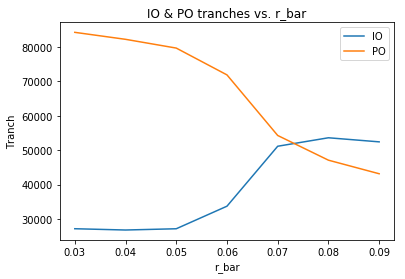

In [7]:
plt.plot(rbar_seq, IO_seq, label = "IO")
plt.plot(rbar_seq, PO_seq, label = "PO")
plt.xlabel("r_bar")
plt.ylabel("Tranch")
plt.title("IO & PO tranches vs. r_bar")
plt.legend()
plt.show()

In [9]:
sol_5 = pd.DataFrame({"r_bar": rbar_seq,
                     "IO": IO_seq,
                     "PO": PO_seq})
sol_5 = sol_5[["r_bar", "IO", "PO"]]
sol_5

,r_bar,IO,PO
0,0.03,27215.097547,84241.339954
1,0.04,26843.749045,82213.947006
2,0.05,27207.221463,79670.896893
3,0.06,33759.703039,71883.176964
4,0.07,51166.959320,54293.358371
5,0.08,53626.625210,47120.357114
6,0.09,52440.819157,43180.398371
